**TODO**

<ol>
<li><strike>Check if Note number conversion is correct</strike></li>
<li><strike>Create a tonic dict for existing makamlar</strike></li>
<li>Relation between measures are indicated how? (Extensions, glissando, my vocab is poor here)</li>
<li>Deal with Multi-part scores. Probably not possible in makam music</li>
</ol>

**STATISTICS**

<ol>
<li>Note histogram (octave folded, just 53-TET pitch class)</li>
<li>Melodic line plot</li>
<li>Return to tonic durations (how many notes did it take to return to tonic)</li>
<li>Return to tonic pitch ranges (what pitch range did the return to tonic cover)</li>
<li>General note range</li>
<li>Histogram of note durations</li>
<li>Histogram of position of tonic in measure</li>
<li>Interval histogram</li>

**Discoveries**
   - Alter<br>
"-1, -4, -5, -8, +1, +4, +5, +8" Comma alterations of the accidentals in the 53 Comma Scale.
   - "divisions" attribute<br>
https://github.com/burakuyar/MusicXMLConverter/blob/master/musicxmlconverter/symbtr2musicxml.py
                measure_len = (temp_num_beats * num_divs *
                           4 / float(temp_beat_type))

**Questions**              

- RESEARCH QUESTION: What are other components of Turkish makam music that define the makam?

- Can makam music have time signature change?
- Is makam music actually strictly following the theoretical tonic for a specific makam?



```Measure
    0: attributes ( even if no note is present) 
        sometimes empty, o.w.
        'divisions'
        'key'
        'time'
    1,.. notes ```

![alt text](fig1.png "Title")

In [1]:
PITCH_CLASS = {
        'C':0,
        'D':9,
        'E':18,
        'F':22,
        'G':31,
        'A':40,
        'B':44
}

# sharps ???????
ACCIDENTALS = {
        'quarter-flat':-1,
        'slash-flat':-4,
        'flat':-5,
        'double-slash-flat':-8,
        'natural': 0,
        'quarter-sharp':+1,
        'sharp':+4,
        'slash-quarter-sharp':+5,  
        'slash-sharp':+8
}

# a tonic reference https://www.researchgate.net/figure/Twenty-four-makams-that-appear-in-this-paper-are-represented-in-the-AEU-system-Special_fig2_276132262
# for those not in the paper, cross-referenced from recordings and other sources e.g. http://muzik.name/
TONICS = {
        'Uşşak': PITCH_CLASS['G'],
        'Nihâvent': PITCH_CLASS['G'],
        'Kürdîlihicazkâr': PITCH_CLASS['D'],
        'Sabâ': PITCH_CLASS['D'],
        'Rast': PITCH_CLASS['C'],
        'Mâhur': PITCH_CLASS['G'],
        'Segâh': PITCH_CLASS['A'] + ACCIDENTALS['sharp'],
        'Hicaz': PITCH_CLASS['G'],
        'Hüseynî': PITCH_CLASS['G'],
        'Bûselik': PITCH_CLASS['G'] + ACCIDENTALS['sharp'],
        'Muhayyer': PITCH_CLASS['G'],
        'Hüzzam': PITCH_CLASS['A'],
        'Hicazkâr': PITCH_CLASS['F'] + ACCIDENTALS['sharp'],
        'Beyâtî': PITCH_CLASS['G'],
        'Karcığar': PITCH_CLASS['A'],
        'Acemaşîrân': PITCH_CLASS['F']
}

In [59]:
# Code modified from https://github.com/burakuyar/Tools/blob/master/musicxml_player.py
# Data from https://github.com/sertansenturk/SymbTr

import os
import glob
from collections import defaultdict

import numpy as np

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

# DATA_DIR=os.path.join(os.getcwd(), 'data')
DATA_DIR = '/home/chris/Documents/makam_MusicXML'

In [3]:
def read_score(score_path):
    tree=ET.parse(score_path)
    root=tree.getroot()
    return root

def get_composer_info(root):
    composition_name=root.find('work/work-title').text
    composer_name=root.find('identification/creator').text
    return composition_name,composer_name 

def get_makam_form_usul(root):
    makam_form_usul=root.find('part/measure/direction/direction-type/words').text.split(', ')
    makam=makam_form_usul[0].split(': ')[-1]
    form=makam_form_usul[1].split(': ')[-1]
    usul=makam_form_usul[2].split(': ')[-1][:-1]
    return makam, form, usul

def note_to_number(p,o,a):
    """Convert NoteAEU to AEU53 Comma numbering. """
    if p!='Rest':
        return 53*(int(o)+1) + PITCH_CLASS[p] + ACCIDENTALS[a]
    else:
        return -1

def parse_notes(root, record_embellishment=True):
    """
    Returns a 2D array of [[measure_idx,note_idx,note_duration,note_number, *note_name]]
    Note name can only be "PitchClass Octave", "PitchClass Octave Accidental" or "Rest"
    If a note_name is not Rest and it has zero duration, that note is an embellishment.
    """
    notes=[]
    for m_idx,measure in enumerate(root.findall('part/measure')):   
        if len(measure.findall('note'))>0: # Check if the measure contains at least one note
            grace_count=0 # Count grace notes in case you don't want to record them
            for n_idx,note in enumerate(measure.findall('note')):
                dur=note.find('duration')
                if dur is None:
                    if not record_embellishment:
                        grace_count+=1
                        continue # skip the grace note
                    else:
                        dur='0' # Embellishment/Grace Note
                else:
                    dur=dur.text
                step=note.find('pitch/step')
                if step is not None:
                    step=step.text
                    octave=note.find('pitch/octave').text
                    acc = note.find('accidental')
                    if acc is None:
                        n=[step,octave,'natural']
                    else:
                        n=[step,octave,acc.text]
                else:
                    rest = note.find('rest')
                    assert rest is not None, "The note doesn't have a pitch and is not a rest!"
                    n=['Rest','','']
                note_number=note_to_number(*n)
                note = [m_idx, n_idx-grace_count, dur, note_number, *n]
                notes.append(note)
    return np.array(notes)

def get_time_signatures(root):
    """Returns all time signatures in the score as a list of tupples.
    Assumes it is possible to have time change in makam pieces."""
    beats = [t.text for t in root.findall('part/measure/attributes/time/beats')]
    types = [t.text for t in root.findall('part/measure/attributes/time/beat-type')]
    all_time_signatures=[(int(b),int(t)) for b,t in zip(beats,types)]
    return all_time_signatures

def get_bpm(root):
    return float(root.find('part/measure/direction/sound').attrib['tempo'])

def get_divisions(root):
    return float(root.find('part/measure/attributes/divisions').text)

def find_key_signature_accidentals(root):
    notes, accidentals = [], []
    for k in root.iter('key'):
        for ks in k.findall('key-step'):
            notes.append(ks.text)
        for ka in k.findall('key-accidental'):
            accidentals.append(ka.text)
    return ['{} {}'.format(n,k) for n,k in zip(notes,accidentals)]

def find_all_accidentals(root):
    return set([a.text for a in root.iter('accidental')])

def get_measure_change_indices(composition):
    """Returns the indices of notes in the composition where the next measure begins."""
    measure_indices=composition['notes'][:,0].astype(int)
    measure_changes=np.insert(np.where(np.diff(measure_indices, prepend=0))[0],0,0)
    return measure_changes

# -> Find all xml files in the DATA_DIR

In [4]:
score_paths = glob.glob(DATA_DIR+'/*.xml')
print(f'There are {len(score_paths)} scores in the directory.')

There are 2200 scores in the directory.


# -> Process

### --> Process 1 XML File

In [5]:
# Read one xml file to a tree structure
score_path=score_paths[0]
root=read_score(score_path)

In [6]:
# Get necessary information
composition_name,composer_name =get_composer_info(root)
print(f'Composition: {composition_name}')
print(f'Composer: {composer_name}')
makam,form,usul=get_makam_form_usul(root)
print(f'Makam: {makam}')
print(f'Form: {form}')
print(f'Usul: {usul}')
time_signatures=get_time_signatures(root)
print(f'Time Signature(s): {time_signatures}')
bpm=get_bpm(root)
print(f'BPM: {bpm}')
divs=get_divisions(root)
print(f'Divisions: {divs}')
key_signature_accidentals=find_key_signature_accidentals(root)
print(f'Accidental(s) in the key signature: {key_signature_accidentals}')
notes=parse_notes(root, record_embellishment=False)

Composition: Uşşak Seyir
Composer: Rauf Yektâ
Makam: Uşşak
Form: Seyir
Usul: Semâî
Time Signature(s): [(3, 4)]
BPM: 120.0
Divisions: 96.0
Accidental(s) in the key signature: ['B quarter-flat']


In [7]:
print('Meas Pos Dur  Num   STE Oct  Acc')
print('='*len('Meas Pos Dur  Num   STE Oct  Acc'))
for n in notes:
    print(n)   

Meas Pos Dur  Num   STE Oct  Acc
['0' '0' '192' '296' 'G' '4' 'natural']
['0' '1' '96' '305' 'A' '4' 'natural']
['1' '0' '192' '305' 'A' '4' 'natural']
['1' '1' '96' '305' 'A' '4' 'natural']
['2' '0' '192' '305' 'A' '4' 'natural']
['2' '1' '96' '308' 'B' '4' 'quarter-flat']
['3' '0' '192' '296' 'G' '4' 'natural']
['3' '1' '96' '-1' 'Rest' '' '']
['4' '0' '192' '305' 'A' '4' 'natural']
['4' '1' '96' '308' 'B' '4' 'quarter-flat']
['5' '0' '96' '327' 'D' '5' 'natural']
['5' '1' '96' '318' 'C' '5' 'natural']
['5' '2' '96' '308' 'B' '4' 'quarter-flat']
['6' '0' '192' '308' 'B' '4' 'quarter-flat']
['6' '1' '96' '305' 'A' '4' 'natural']
['7' '0' '96' '296' 'G' '4' 'natural']
['7' '1' '192' '291' 'F' '4' 'sharp']
['8' '0' '192' '296' 'G' '4' 'natural']
['8' '1' '96' '305' 'A' '4' 'natural']
['9' '0' '192' '305' 'A' '4' 'natural']
['9' '1' '96' '305' 'A' '4' 'natural']
['10' '0' '192' '305' 'A' '4' 'natural']
['10' '1' '96' '308' 'B' '4' 'quarter-flat']
['11' '0' '192' '296' 'G' '4' 'natural']


### --> Process All XML Files

In [8]:
# Create a dictionary containing all the necessary information.
dataset=defaultdict(list)
for score_path in score_paths:
    root=read_score(score_path)
    makam,form,usul=get_makam_form_usul(root)
    composition_name,composer_name =get_composer_info(root)
    score_dict={'composition': composition_name,
                'composer': composer_name,
                'form': form,
                'usul': usul,
                'time_signatures': get_time_signatures(root),
                'bpm': get_bpm(root),
                'divs': get_divisions(root),
                'key_sigsnature_accidentals': find_key_signature_accidentals(root),
                'notes': parse_notes(root, record_embellishment=False)
                }
    dataset[makam].append(score_dict)
#print(list(dataset.keys()))    

In [9]:
print('Number of scores for each makam:')
for makam,dct in dataset.items():
    print(f'{makam}: {len(dct)}')

Number of scores for each makam:
Uşşak: 118
Nihâvent: 130
Kürdîlihicazkâr: 70
Eviç: 34
Sabâ: 66
Acemkürdî: 37
Rast: 109
Mâhur: 88
Kürdî: 14
Segâh: 92
Nühüft: 3
Hicaz: 157
Hicaz-Hümâyûn: 38
Şevk'efzâ: 11
Hüseynî: 92
Bûselik: 57
Nişâburek: 26
Muhayyer: 67
Hüzzam: 96
Nevâ: 21
Arazbâr: 4
Hicazkâr: 79
Hüzzam-ı-Cedîd: 1
Rehâvî: 6
Beyâtî: 62
Beyâtî-Arabân: 7
Şehnâzbûselik: 8
Sultânîyegâh: 22
Karcığar: 53
Ferahfezâ: 17
Segâh-Mâye: 4
Çargâh(Yeni): 7
Sûzinâk-Zirgüle: 26
Acemaşîrân: 63
Sultan-ı-Irak: 1
Şehnâz: 25
Bestenigâr: 13
Gerdâniye: 26
Sipihr: 1
Peyk-i-Neşat: 1
Acemtarab: 1
Hisarbûselik: 20
Nev'eser: 8
Şevk-ı-Cedîd: 1
Sûzidilârâ: 7
Isfahân: 20
Şedarabân: 15
Muhayyerkürdî: 32
Sûzinâk: 19
Beste-Isfahan: 3
Rûy-i-Irâk: 2
Tâhir: 31
Sûzidil: 19
Acem: 7
Vech-i-Arazbâr: 1
Yegâh: 22
Pençgâh-ı-Asl: 1
Evcârâ: 9
Nikrîz: 25
Aşkefzâ: 3
Gülizâr: 7
Tâhirbûselik: 3
Pesendîde: 4
Dilkeşhâveran: 4
Müstear: 6
Şevkutarab: 3
Muhayyerbûselik: 1
Tarz-ı-Nevîn: 2
Zâvil: 9
Gonca-i-Rânâ: 1
Hüseynîgülizâr: 1
Hicaz-Uzzâl

In [10]:
# Remove makamlar without enough scores
THRESHOLD=50
subset={k:v for k,v in dataset.items() if len(v)>=THRESHOLD}
count=0
for makam, dct in subset.items():
    print(f'{makam}: {len(dct)}')
    count += len(dct)
print("Number of makamlar:", len(subset))
print("Valid score count:", count)

Uşşak: 118
Nihâvent: 130
Kürdîlihicazkâr: 70
Sabâ: 66
Rast: 109
Mâhur: 88
Segâh: 92
Hicaz: 157
Hüseynî: 92
Bûselik: 57
Muhayyer: 67
Hüzzam: 96
Hicazkâr: 79
Beyâtî: 62
Karcığar: 53
Acemaşîrân: 63
Number of makamlar: 16
Valid score count: 1399


In [11]:
single_makam=subset['Muhayyer']
composition=single_makam[0]
composition

{'composition': 'Humârı Yok Bozulmaz',
 'composer': 'Hacı Ârif Bey',
 'form': 'Şarkı',
 'usul': 'Aksak',
 'time_signatures': [(9, 8)],
 'bpm': 77.0,
 'divs': 96.0,
 'key_sigsnature_accidentals': ['B quarter-flat', 'F sharp'],
 'notes': array([['0', '0', '48', ..., 'G', '5', 'natural'],
        ['0', '1', '96', ..., 'G', '5', 'natural'],
        ['0', '2', '48', ..., 'A', '5', 'natural'],
        ...,
        ['40', '9', '144', ..., 'A', '4', 'natural'],
        ['41', '0', '48', ..., 'G', '4', 'natural'],
        ['41', '1', '96', ..., 'A', '4', 'natural']], dtype='<U21')}

In [12]:
# Find all the note numbers and obsere if a number corresponds to multiple names
# Due to the problems in the theory, we expect not seeing a 1-1 correspondance
check=defaultdict(set)
for makam_dict in dataset.values():
    for composition in makam_dict:
        for row in zip(composition['notes'][:,-4:]):
            n,p,o,a=row[0]
            check[n].add(f'{p}{o} {a}')
check = {k: check[k] for k in sorted(check)}
check

{'-1': {'Rest '},
 '243': {'G3 natural'},
 '251': {'B3 flat'},
 '252': {'A3 natural'},
 '255': {'B3 quarter-flat'},
 '256': {'B3 natural'},
 '265': {'C4 natural'},
 '269': {'C4 sharp'},
 '274': {'D4 natural'},
 '278': {'D4 sharp', 'E4 flat'},
 '279': {'E4 slash-flat'},
 '282': {'E4 quarter-flat'},
 '283': {'E4 natural'},
 '287': {'E4 sharp', 'F4 natural'},
 '288': {'E4 slash-quarter-sharp', 'F4 quarter-sharp'},
 '291': {'F4 sharp'},
 '292': {'F4 slash-quarter-sharp', 'G4 slash-flat'},
 '295': {'G4 quarter-flat'},
 '296': {'G4 natural'},
 '300': {'A4 flat', 'G4 sharp'},
 '301': {'A4 slash-flat', 'G4 slash-quarter-sharp'},
 '304': {'A4 quarter-flat', 'B4 flat'},
 '305': {'A4 natural', 'B4 slash-flat'},
 '308': {'B4 quarter-flat'},
 '309': {'A4 sharp', 'B4 natural'},
 '313': {'A4 slash-sharp', 'B4 sharp'},
 '314': {'C5 slash-flat'},
 '317': {'C5 quarter-flat'},
 '318': {'C5 natural'},
 '322': {'C5 sharp', 'D5 flat'},
 '323': {'C5 slash-quarter-sharp', 'D5 slash-flat'},
 '326': {'C5 slash-

In [13]:
# Get the notes of each measure, disregard note lengths
measure_changes = get_measure_change_indices(composition)
for i in range(len(measure_changes[:-1])):
    measure_notes = composition['notes'][measure_changes[i]:measure_changes[i+1],3]
    print(f'Measure: {i}')
    print(measure_notes)
    print()

Measure: 0
['349' '340' '340' '336' '340' '349' '358' '349' '361' '358' '349' '340'
 '349' '340' '349' '358' '349' '340' '336' '349' '340' '336' '327' '318'
 '-1' '361' '358' '349' '340' '349' '358' '361' '358' '349' '349' '340'
 '336' '340' '349' '340' '336' '349' '-1' '349' '340' '349' '327' '331'
 '340' '331' '327' '318' '331' '327' '327' '318' '318' '308' '318' '-1']

Measure: 1
['349' '340' '340' '335' '327' '340' '331' '331' '327' '318' '331' '327'
 '327' '318' '308' '318' '327' '331' '327' '318' '308' '305' '296' '305'
 '308' '318' '327' '331' '327' '318' '318' '-1' '335' '340' '349' '358'
 '361' '358' '349' '340' '380' '371' '361' '358' '349' '358' '361' '358'
 '349' '340' '349' '340' '349']

Measure: 2
['-1' '340' '349' '340' '361' '361' '358' '361' '358' '349' '340' '349'
 '340' '-1' '349' '358' '361' '358' '349' '340' '349' '358' '349' '371'
 '361' '358' '361' '358' '349' '340' '349' '340' '349' '-1']

Measure: 3
['349' '340' '349' '340' '349' '358' '349' '358' '361' '358' '

# -> Score statistics

### --> Note histogram

In [88]:
# store aggregate histograms for pieces belonging to makam
# note_histograms[makam_name] = 1x53 np.array
note_histograms = {}
note_idx = np.asarray(range(0, 53))

for makam, pieces in subset.items():
    note_histograms[makam] = np.zeros(53, dtype=np.int64)
    for piece in pieces:
        # extract column of index 3 (note value)
        notes = piece['notes'][:, 3].astype(np.int64)
        # remove rests
        notes = notes[notes != -1]
        # octave fold
        for i in range(notes.shape[0]):
            notes[i] = notes[i] % 53       
        # extract and add histogram
        note_histograms[makam] += np.histogram(notes, 
                                               bins=53,
                                               density=False)[0]

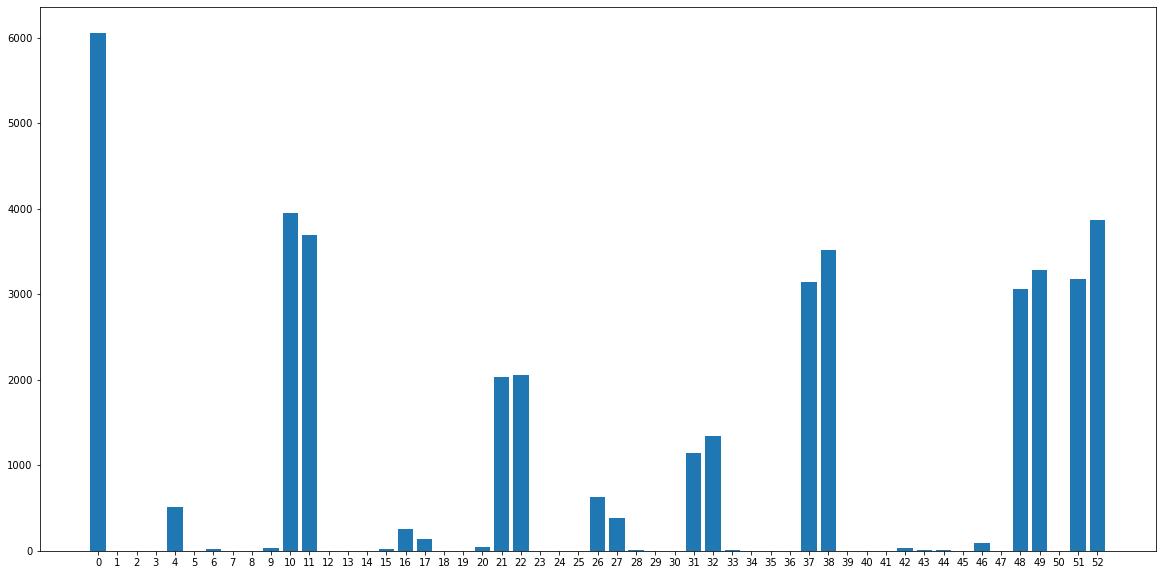

In [93]:
fig_rast = plt.figure(figsize=(20, 10))
bar_rast = plt.bar(x=note_idx, height=note_histograms['Rast'])
ticks_rast = plt.xticks(note_idx)